# Обучение сиамской сети для различия двух объектов

Обучение на данных MOT20Ext

In [3]:
import albumentations as A
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from torchvision import models
import pandas as pd
from os.path import join

from src.config import MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN
from src.models import (SiameseTransfered, SiameseBasicCNN, resnet_grad_l4_unlock,
                        resnet_grad_linear_unlock)
from src.train import (ContrastiveLoss, display_images, get_loaders,
                       train_siamese)
from src.transforms import get_norm_transform, get_resize_transform
from src.config import RESULTS_PATH

In [4]:
torch.cuda.is_available()

True

## Загрузка данных

### Загрузка трансорфмаций

In [5]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])

### Загрузка конфига

In [6]:
dataset_config = {
    'dataset_config': 'mot20_ext-v1c',
    'dataset': 'mot20_ext',
    'dataset_use': 0.01,
    'val_proportion': 0.15,
    'test_proportion': 0.2,
    'batch_size': 16,
    'extra_parameters': {
        'visibility_threshold': 1,
        'negative_proportion': 0.5,
        'frame_distance': 0
    }
}

In [7]:
train_loader, val_loader, test_loader = get_loaders(dataset_config, transform=transform)

### Проверка отображения

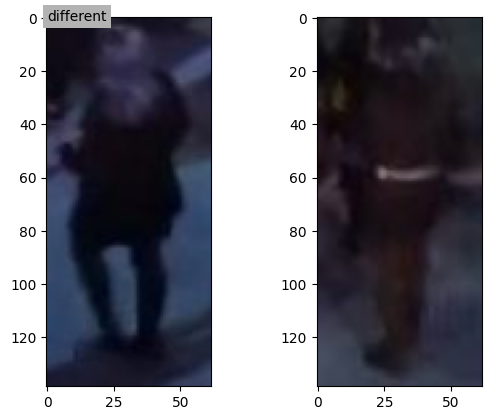

In [8]:
batch = next(iter(train_loader))
x1, x2, y = batch[0][0], batch[1][0], batch[2][0]
display_images((x1, x2), y)

In [9]:
# batch = next(iter(train_loader))
# display_batch(batch)

## Обучение

In [10]:
torch.cuda.is_available()

True

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Обучение Siamese over ResNet18, layer4 unfreeze

Параметры:
- Adam
- ContrastiveLoss
- Threshold = 0.25
- LR = 0.001 

In [12]:
model_rn18_l4 = SiameseTransfered(
    models.resnet18(pretrained=True),
    freeze_grad_fn=resnet_grad_l4_unlock,
    name='siamese_resnet18_linear'
)
model_rn18_l4 = model_rn18_l4.to(device)
lr = 1e-3
criterion = ContrastiveLoss()
optimizer = Adam(model_rn18_l4.parameters(), lr)

/home/nick/reidentification/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nick/reidentification/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=2,
    lr=lr,
    model=model_rn18_l4,
    optimizer=optimizer,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/1:


  3%|▎         | 3/110 [00:02<01:27,  1.22it/s]


KeyboardInterrupt: 

In [18]:
file_path = join(RESULTS_PATH, 'experiments.csv')
config_path = join(RESULTS_PATH, 'configs.csv')
exp_df = pd.read_csv(file_path)
exp_df

,model_name,datetime,epoch_count,optimizer,lr,gamma,step_size,loss_name,val_losses,val_accuracies,best_val_acc,best_val_loss,test_accuracy,dataset_config,extra_parameters
0,siamese_resnet18_linear,2023-05-16 21:04:15.317697,2,Adam,0.001,NaN,NaN,ContrastiveLoss,63.47208150227865;14.547251065572103,0.9791666666666666;0.9583333333333334,0.979167,14.547251,NaN,mot20_ext-v1a,threshold=0.25
1,siamese_resnet18_linear,2023-05-16 21:06:29.426601,2,Adam,0.001,NaN,NaN,ContrastiveLoss,10.053370475769043;8.094988663991293,0.9583333333333334;0.9791666666666666,0.979167,8.094989,NaN,mot20_ext-v1a,threshold=0.25
2,siamese_resnet18_linear,2023-05-16 21:06:46.626192,2,Adam,0.001,NaN,NaN,ContrastiveLoss,6.908087730407715;5.925547281901042,0.9583333333333334;1.0,1.000000,5.925547,NaN,mot20_ext-v1a,threshold=0.25
3,basic_cnn,2023-05-16 21:12:15.115694,6,Adam,0.001,NaN,NaN,ContrastiveLoss,1.7107092142105103;1.6221161603927612;1.626214...,0.8375;0.9;0.925;0.95;0.7875;0.925,0.950000,1.585436,NaN,mot20_ext-v1b,threshold=0.25
4,basic_cnn,2023-05-16 21:13:44.219291,6,Adam,0.010,0.1,2.0,ContrastiveLoss,1.6568951606750488;1.6641317844390868;1.532974...,0.85;0.85;0.9125;0.9125;0.95;0.9,0.950000,1.532974,NaN,mot20_ext-v1b,threshold=0.25
5,basic_cnn,2023-05-16 21:17:44.904547,6,Adam,0.010,0.1,2.0,ContrastiveLoss,1.5339941811561584;1.5315347909927368;1.524272...,0.9025;0.92;0.89;0.92;0.9125;0.925,0.925000,1.483988,NaN,mot20_ext-v1c,threshold=0.25
6,basic_cnn,2023-05-16 21:27:46.559418,6,Adam,0.010,0.1,2.0,ContrastiveLoss,1.4901376700401305;1.534993691444397;1.4714239...,0.9075;0.915;0.91;0.9225;0.9075;0.91,0.922500,1.443070,NaN,mot20_ext-v1c,threshold=0.25


### Обучение Siamese over ResNet18, last linear only

In [ ]:
model_rn18_linear = SiameseTransfered(
    models.resnet18(pretrained=True),
    freeze_grad_fn=resnet_grad_linear_unlock,
    name='siamese_resnet18_linear'
)

lr = 1e-3
criterion = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr)

model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=2,
    lr=lr,
    model=model_rn18_l4,
    optimizer=optimizer,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/2:


100%|██████████| 22/22 [00:11<00:00,  1.88it/s]

train Loss: 2298.1805 Acc: 0.7301



100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

val Loss: 1708.0820 Acc: 0.7250
Model saved at resnet_l4.pth
Epoch 1/2:



100%|██████████| 22/22 [00:11<00:00,  1.95it/s]

train Loss: 993.2562 Acc: 0.7273



100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

val Loss: 917.9447 Acc: 0.7875
Model saved at resnet_l4.pth
Epoch 2/2:



100%|██████████| 22/22 [00:10<00:00,  2.00it/s]

train Loss: 533.1695 Acc: 0.7642



100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

val Loss: 474.1536 Acc: 0.7125


### Обучение BasicCNN

In [15]:
model = SiameseBasicCNN().to(device)
lr = 1e-2
criterion = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=6,
    lr=lr,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/5:


/home/nick/reidentification/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 110/110 [00:10<00:00, 10.48it/s]

train Loss: 1.5320 Acc: 0.7864



100%|██████████| 25/25 [00:01<00:00, 21.58it/s]

val Loss: 1.4901 Acc: 0.9075
Model saved at basic_cnn.pth
Epoch 1/5:



100%|██████████| 110/110 [00:10<00:00, 10.82it/s]

train Loss: 1.3798 Acc: 0.7841



100%|██████████| 25/25 [00:01<00:00, 22.89it/s]

val Loss: 1.5350 Acc: 0.9150
Model saved at basic_cnn.pth
Epoch 2/5:



100%|██████████| 110/110 [00:10<00:00, 10.66it/s]

train Loss: 1.3538 Acc: 0.7898



100%|██████████| 25/25 [00:01<00:00, 22.71it/s]

val Loss: 1.4714 Acc: 0.9100
Epoch 3/5:



100%|██████████| 110/110 [00:10<00:00, 10.97it/s]

train Loss: 1.3405 Acc: 0.7881



100%|██████████| 25/25 [00:01<00:00, 23.30it/s]

val Loss: 1.4592 Acc: 0.9225
Model saved at basic_cnn.pth
Epoch 4/5:



100%|██████████| 110/110 [00:10<00:00, 10.77it/s]

train Loss: 1.3526 Acc: 0.7693



100%|██████████| 25/25 [00:01<00:00, 23.64it/s]

val Loss: 1.4431 Acc: 0.9075
Epoch 5/5:



100%|██████████| 110/110 [00:09<00:00, 11.05it/s]

train Loss: 1.3339 Acc: 0.7949



100%|██████████| 25/25 [00:01<00:00, 23.69it/s]

val Loss: 1.4870 Acc: 0.9100


### Результаты

In [16]:
def draw_plot(y1, y2, label):
    epoch = range(len(y1))
    fig, ax = plt.subplots()
    ax.plot(epoch, y1, label=f'{label} loss')
    ax.plot(epoch, y2, label=f'{label} accuracy')
    ax.grid()
    plt.xlabel('epoch count')
    plt.ylabel('metrics')
    plt.title(label)
    plt.legend()
    fig.savefig("test.png")
    plt.show()

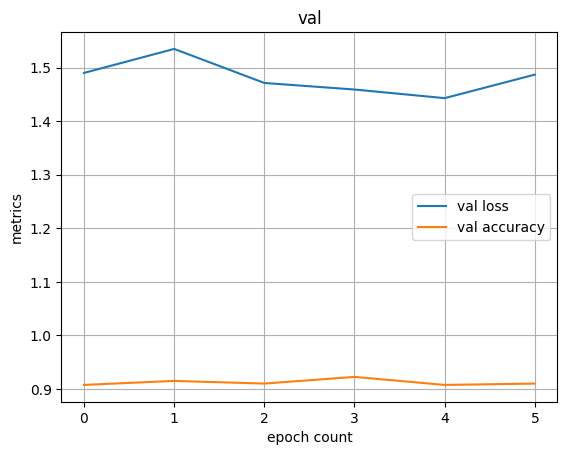

In [17]:
draw_plot(results['val'][0], results['val'][1], 'val')